In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [2]:
# Install ONLY what's necessary
!pip install efficientnet-pytorch --no-deps --quiet
print("✅ Ready for training!")

  Preparing metadata (setup.py) ... done
✅ Ready for training!


Installs the efficientnet-pytorch library (without extra dependencies) to use EfficientNet in PyTorch.

⚠️ Note: Using --no-deps --quiet keeps the environment clean and avoids unnecessary package conflicts.

In [3]:
# Essential imports
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader  # <-- THIS IS CRUCIAL
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from efficientnet_pytorch import EfficientNet

# Verify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

Using cuda


Imports necessary libraries for data handling, model training, and visualization.

Checks if a GPU (CUDA) is available for faster training.

🔹 Key Libraries:

torch (PyTorch for deep learning)

torchvision.transforms (image preprocessing)

PIL (image loading)

seaborn (confusion matrix visualization)



In [4]:
data_dir = '/kaggle/input/brain-tumor-mri-dataset/'
classes = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Create DataFrame
image_paths = []
labels = []
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, 'Training', class_name)
    for img in os.listdir(class_dir):
        if img.endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(class_dir, img))
            labels.append(class_idx)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 4569, Test: 1143


Loads MRI images from the dataset directory.

Creates a Pandas DataFrame with image_path and label columns.

Splits data into 80% train and 20% test sets using train_test_split.

🔹 Why random_state=42? 

Ensures reproducibility (same train-test split every run).

In [5]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset Class
class BrainMRIDataset(Dataset):  # Now 'Dataset' is recognized
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['label']
        
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets
train_dataset = BrainMRIDataset(train_df, transform)
test_dataset = BrainMRIDataset(test_df, transform)

Defines image transformations (resize, normalize, etc.).

Creates a custom PyTorch Dataset to load images and labels.

🔹 Why Normalize with ImageNet stats? 

EfficientNet was pretrained on ImageNet, so we use the same mean/std for best results.



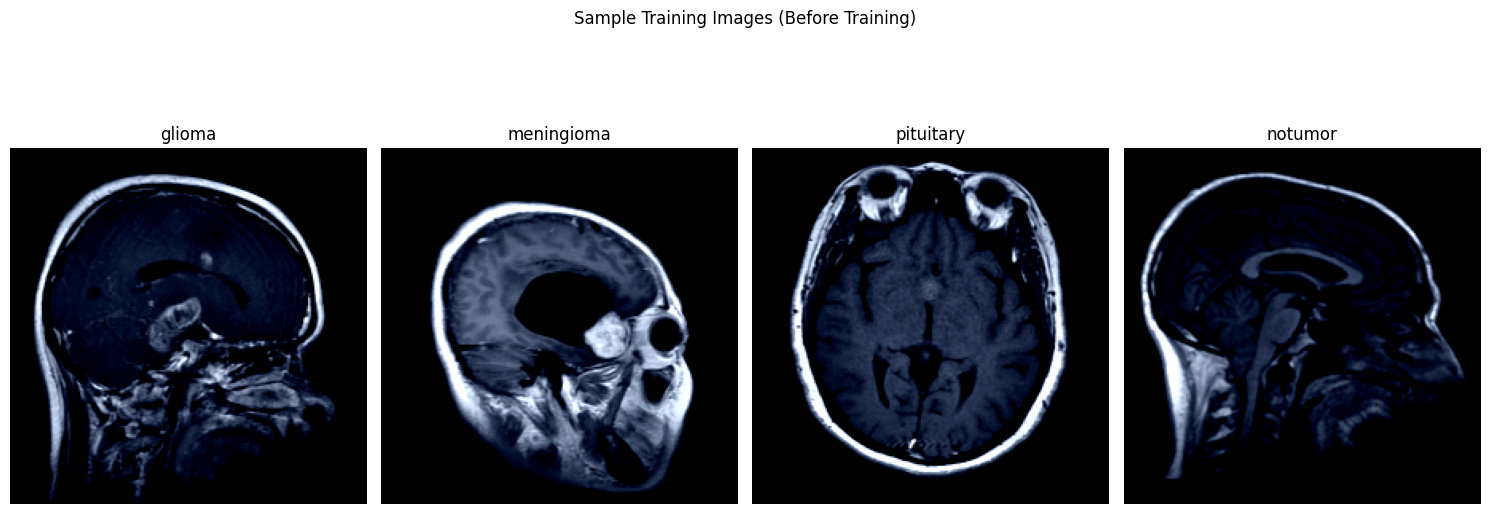

In [6]:
# %% [Cell X: Before-Training Visualization] 
# Add this right after your dataset creation cell (train_dataset = ...)
# and BEFORE your training loop cell

# Before-training samples
plt.figure(figsize=(15,5))
for i, cls in enumerate(classes):
    # Get first image of each class
    sample = next(img for img, label in train_dataset if label == i)
    plt.subplot(1,4,i+1)
    plt.imshow(sample.permute(1,2,0).numpy() * 0.5 + 0.5)  # Denormalize
    plt.title(cls)
    plt.axis('off')
plt.suptitle("Sample Training Images (Before Training)", y=1.1)
plt.tight_layout()
plt.show()

Displays one sample image per class before training.

Helps verify that data loading and transforms are working correctly.

🔹 Why permute(1,2,0)? PyTorch uses (C,H,W), but Matplotlib expects (H,W,C)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Creates PyTorch DataLoaders for efficient batch processing.

shuffle=True for training (prevents overfitting).

shuffle=False for testing (consistent evaluation).

In [8]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, len(classes))
model = model.to(device)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False
for layer in [model._conv_head, model._bn1, model._fc]:
    for param in layer.parameters():
        param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 44.8MB/s]


Loaded pretrained weights for efficientnet-b0


Loads pretrained EfficientNet-B0 and modifies the final layer for 4 classes.

Freezes all layers except the last few (prevents overfitting, speeds up training).

Uses CrossEntropyLoss (standard for classification) and Adam optimizer.



In [9]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(15):
    model.train()
    train_loss, train_correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
    
    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
    
    # Store metrics
    epoch_train_loss = train_loss/len(train_loader)
    epoch_train_acc = 100*train_correct/len(train_dataset)
    epoch_val_loss = val_loss/len(test_loader)
    epoch_val_acc = 100*val_correct/len(test_dataset)
    
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/15:")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%")
    print(f"  Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%\n")

Epoch 1/15:
  Train Loss: 0.4135 | Train Acc: 85.34%
  Val Loss: 0.3568 | Val Acc: 87.23%

Epoch 2/15:
  Train Loss: 0.2077 | Train Acc: 92.34%
  Val Loss: 0.4149 | Val Acc: 85.30%

Epoch 3/15:
  Train Loss: 0.1567 | Train Acc: 94.40%
  Val Loss: 0.5531 | Val Acc: 79.62%

Epoch 4/15:
  Train Loss: 0.1120 | Train Acc: 96.06%
  Val Loss: 0.2885 | Val Acc: 90.20%

Epoch 5/15:
  Train Loss: 0.0865 | Train Acc: 97.46%
  Val Loss: 0.1777 | Val Acc: 94.31%

Epoch 6/15:
  Train Loss: 0.0766 | Train Acc: 97.44%
  Val Loss: 0.1116 | Val Acc: 96.59%

Epoch 7/15:
  Train Loss: 0.0651 | Train Acc: 97.88%
  Val Loss: 0.1095 | Val Acc: 95.63%

Epoch 8/15:
  Train Loss: 0.0574 | Train Acc: 98.16%
  Val Loss: 0.1073 | Val Acc: 96.33%

Epoch 9/15:
  Train Loss: 0.0432 | Train Acc: 98.56%
  Val Loss: 0.0962 | Val Acc: 96.76%

Epoch 10/15:
  Train Loss: 0.0387 | Train Acc: 98.86%
  Val Loss: 0.0811 | Val Acc: 97.73%

Epoch 11/15:
  Train Loss: 0.0362 | Train Acc: 98.75%
  Val Loss: 0.1062 | Val Acc: 96.41

Trains the model for 15 epochs.

Tracks training & validation loss/accuracy.

Uses model.train() and model.eval() to switch between training and evaluation modes.

🔹 Why torch.no_grad()? 

Disables gradient computation during validation (faster, less memory).

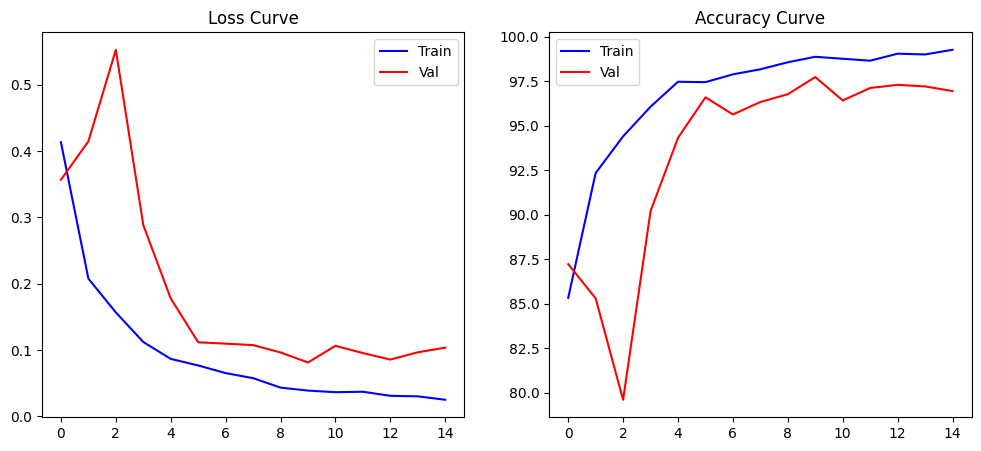

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train')
plt.plot(val_losses, 'r-', label='Val')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, 'b-', label='Train')
plt.plot(val_accs, 'r-', label='Val')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

Visualizes training vs. validation loss & accuracy.

Helps detect overfitting (if validation loss increases while training loss decreases).

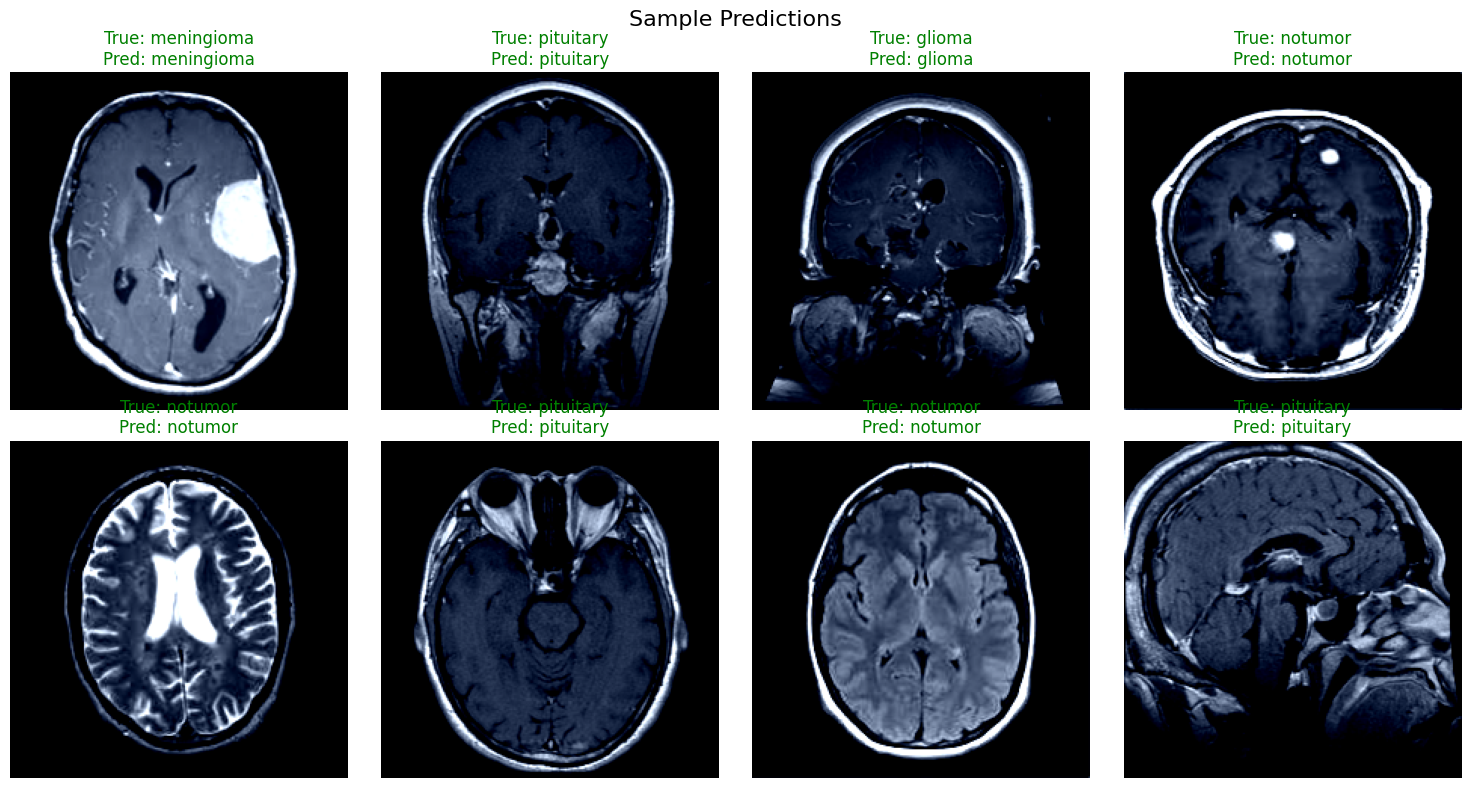

In [11]:
model.eval()
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for i in range(8):  # Show 8 samples
    img, label = test_dataset[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax().item()
    
    axes[i//4, i%4].imshow(img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[i//4, i%4].set_title(f"True: {classes[label]}\nPred: {classes[pred]}", 
                            color='green' if pred == label else 'red')
    axes[i//4, i%4].axis('off')
plt.suptitle("Sample Predictions", fontsize=16)
plt.tight_layout()
plt.show()

Displays 8 test images with true vs. predicted labels

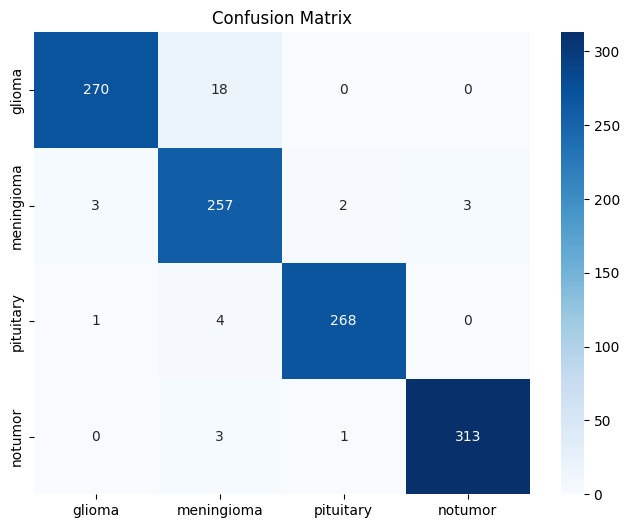

In [12]:
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.show()

Shows class-wise performance (which tumors are confused with others).

Helps identify weak classes (e.g., if glioma is often misclassified as meningioma)